In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.set_device(0)
import os
from pathlib import Path
import json
from fastai import *
from fastai.dataset import *
from fastai.conv_learner import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patheffects

## Load Data

In [3]:
data_dir = Path('/mnt/data/extracts/pascal')
JPEGS = data_dir/'VOCdevkit/VOC2007/JPEGImages/'

In [4]:
train = json.load(open(data_dir/'pascal_train2007.json'))
val = json.load(open(data_dir/'pascal_val2007.json'))
test = json.load(open(data_dir/'pascal_test2007.json'))

### Create File Lookups

In [5]:
all_images = train['images'] + val['images'] + test['images']
fnid = {x['file_name']: x['id'] for x in all_images}

### Create DataFrames

In [6]:
def bb_np(bbox_hw):
    return [bbox_hw[1], bbox_hw[0], 
            bbox_hw[1] + bbox_hw[3], 
            bbox_hw[0] + bbox_hw[2]]

def bb_hw(bbox_np):
    return [bbox_np[1], bbox_np[0], 
            bbox_np[3] - bbox_np[1],
            bbox_np[2] - bbox_np[0]]

def create_df(d):
    anno = d['annotations']
    fnid = [{'file_name': x['file_name'], 'image_id': x['id']} for x in d['images']]
    cats = [{'category_id': x['id'], 'category_name': x['name']} for x in d['categories']]
    anno_df = pd.DataFrame.from_dict(anno)
    fname_df = pd.DataFrame.from_dict(fnid)
    cat_df = pd.DataFrame(cats)
    df = pd.merge(anno_df, cat_df, how='inner', on='category_id')
    df = pd.merge(df, fname_df, how='inner', on='image_id')
    df['bbox_np'] = df['bbox'].apply(lambda x: bb_np(x))
    df = df.loc[df.ignore != 1]
    return df

def get_largest(df):
    return df.sort_values('area', ascending=False).groupby(['image_id']).first().reset_index()

In [7]:
train_df = create_df(train)
val_df = create_df(val)
test_df = create_df(test)
comb_df = pd.concat([train_df, val_df], axis=0)

In [8]:
trn_lrg_df = get_largest(train_df)
val_lrg_df = get_largest(val_df)
comb_lrg_df = get_largest(comb_df)

### Setup Plotting Functions

In [9]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_anno(ax, x, y, anno):
    text = ax.text(x, y, anno, fontsize=14, color='white', weight='bold', 
                   verticalalignment='top')
    draw_outline(text, 1)
    
def draw_rect(ax, bbox, edgecolor='white'):
    x = bbox[0]
    y = bbox[1]
    h = bbox[2]
    w = bbox[3]
    ax.add_patch(patches.Rectangle((x, y), h, w, fill=False, edgecolor=edgecolor, lw=2))
    
def show_img(img, ax=None, figsize=(16, 8)):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax
    
def plot_idx(image_id, figsize=(16, 8)):
    rel = comb_lrg_df.loc[comb_lrg_df.image_id == image_id].iloc[0]
    fname = rel.file_name
    cat = rel.category_name
    bbox = rel.bbox
    f_path = JPEGS/fname
    img = open_image(f_path)
    ax = show_img(img, figsize=figsize)
    draw_rect(ax, bbox)
    draw_anno(ax, bbox[0], bbox[1], cat)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Multilabel Classification

In [16]:
TMP = data_dir/'tmp'
TMP.mkdir(exist_ok=True)
MC_CSV = TMP/'MC.CSV'
MODEL = Path('/mnt/models/pascal')
f_model = resnet34
sz = 224

In [17]:
def create_mc_df(df, unique=True):
    df1 = df.copy()
    df1 = df1[['file_name', 'image_id', 'category_name']]
    if unique:
        df2 = (df1.groupby(['file_name', 'image_id'])
               .apply(lambda x: pd.Series({'m_cat': ' '.join(set(x.category_name))}))
               .reset_index())
    else:
        df2 = (df1.groupby(['file_name', 'image_id'])
               .apply(lambda x: pd.Series({'m_cat': ' '.join(x.category_name)}))
               .reset_index())
    df2 = (df2[['file_name', 'm_cat']]
           .rename(columns={'file_name': 'fname'}))
    return df2

In [18]:
def matching_cl(onehot_y, md, thresh=0):
    return list(np.array(md.classes)[np.where(onehot_y > thresh)])

In [19]:
def plot_mc(x, y, thresh=0):
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        show_img(np.squeeze(md.trn_ds.denorm(x[i])), ax=ax, figsize=(12, 8))
        txt_x = 0
        txt_y = 0
        for cl in matching_cl(y[i], md, thresh):
            draw_anno(ax, txt_x, txt_y, cl)
            txt_y += 20
    plt.tight_layout()

In [20]:
mc_df = create_mc_df(train_df)
mc_df.to_csv(MC_CSV, index=False)

In [15]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, 
                       max_zoom=1.1, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(MODEL, JPEGS, MC_CSV, tfms=tfms, skip_header=True)

In [16]:
x, y = list(next(iter(md.trn_dl)))
x, y = to_np(x), to_np(y)

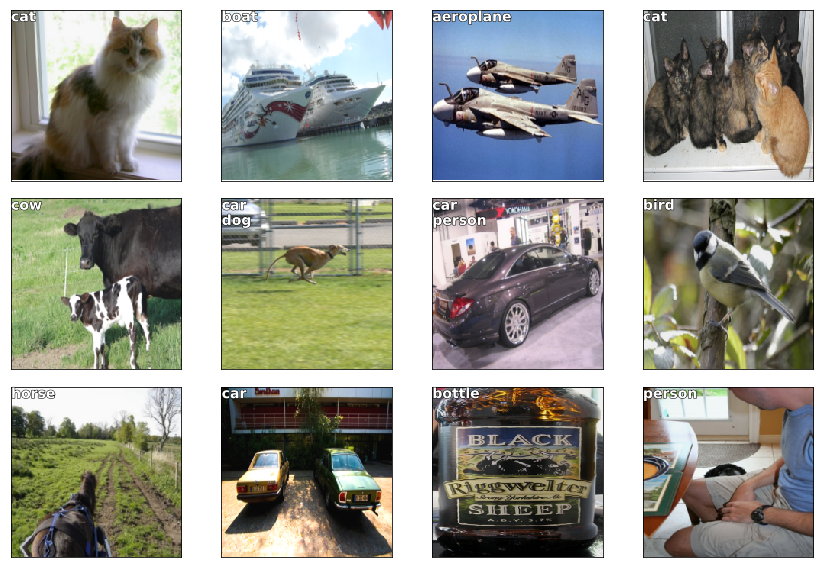

In [156]:
plot_mc(x, y)

In [17]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 26046634.96it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      1.068195   5.01955    0.818134  



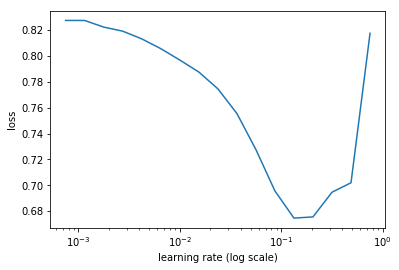

In [18]:
learn.lr_find()
learn.sched.plot()
lr = 2e-2

In [19]:
learn.fit(lr, n_cycle=1, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.303233   0.122145   0.959848  
    1      0.168022   0.081985   0.973603                  
    2      0.120836   0.078955   0.973896                  



[0.07895541, 0.9738957285881042]

In [20]:
learn.fit(lr, n_cycle=1, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                   
    0      0.106918   0.081339   0.97355   
    1      0.086961   0.075432   0.974872                   



[0.07543205, 0.9748722985386848]

In [21]:
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:20<00:03,  1.30it/s, loss=0.347] 

In [22]:
preds = to_np(predict_batch(learn.model, x))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


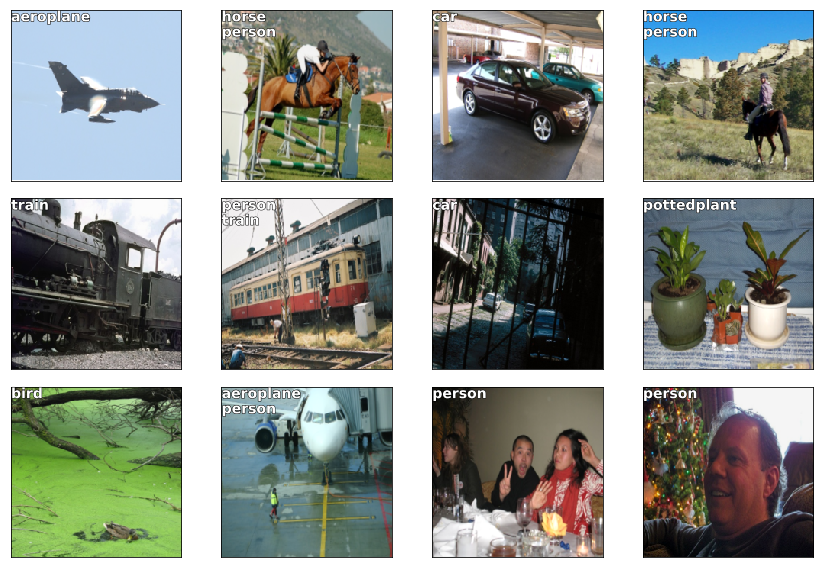

In [24]:
plot_mc(x, y)

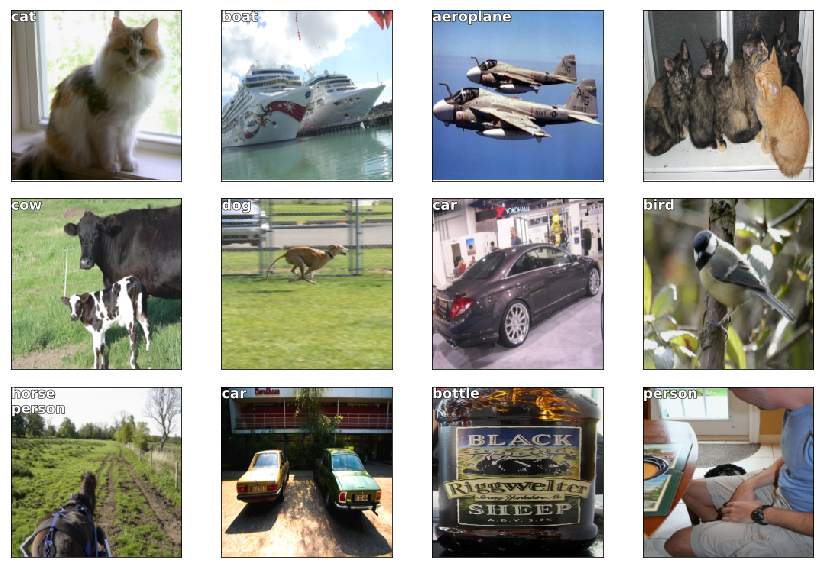

In [164]:
plot_mc(x, preds, 0.5)

## Object Detection with 4x4 Grid of Anchor Boxes

### Setup anchor boxes

In [21]:
grid_size = 4 

def gen_anc_coord(grid_size):
    box_len = (1 - 0)/grid_size
    anc_np = [(0 + i*box_len, 0 + j*box_len, 0 + (i+1)*box_len, 0 + (j+1)*box_len)
           for i in range(grid_size) 
           for j in range(grid_size)]
    return anc_np

In [22]:
anc_np = gen_anc_coord(grid_size)

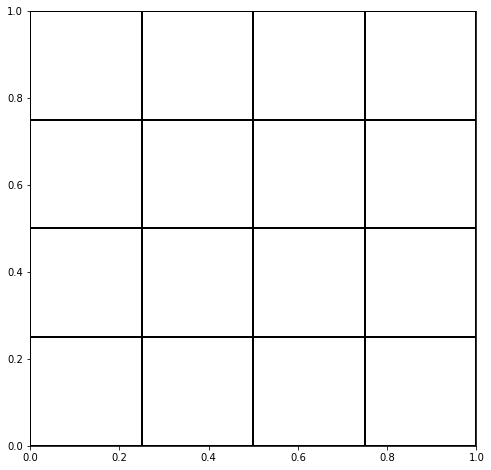

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
for i, x in enumerate(anc_np):
    bb = bb_hw(x)
    draw_rect(ax, bb, edgecolor='black')

### Setup Model Files

In [65]:
def create_od(df):
    df1 = df.copy()
    df1['bbox_np_concat'] = df1['bbox_np'].apply(lambda x: ' '.join([str(i) for i in x]))
    df2 = (df1.groupby(['image_id', 'file_name'])
          .apply(lambda x: pd.Series({'mbb': ' '.join(x.bbox_np_concat),
                                      'mcl': np.array(x.category_id)}))
          .reset_index())
    df2 = (df2[['file_name', 'mbb', 'mcl']]
           .rename(columns={'file_name': 'fname'}))
    return df2

In [53]:
def plot_gt(img, y, ax=None, figsize=(16, 8)):
    ax = show_img(img, ax=ax, figsize=figsize)
    m_bb, m_cl = y
    bb_list = list(np.reshape(m_bb, (int(m_bb.shape[0]/4), 4)))
    for bb in bb_list:
        draw_rect(ax, bb_hw(bb))
        
    txt_x = 0
    txt_y = 0
    for cl in matching_cl(y[i], md, thresh):
        draw_anno(ax, txt_x, txt_y, cl)
        txt_y += 20

In [66]:
MBB_CSV = TMP/'MBB.CSV'
od_df = create_od(train_df)
mbb_df = od_df[['fname', 'mbb']]
mcl_df = od_df[['fname', 'mcl']]
mbb_df.to_csv(MBB_CSV, index=False)
mcl_df.to_csv(MC_CSV, index=False)

In [27]:
f_model = resnet34
sz = 224

In [46]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y, p=0.5),
        RandomRotate(3, tfm_y=tfm_y),
        RandomLighting(0.05, 0.05, tfm_y=tfm_y)]
tfms = tfms_from_model(f_model, sz=sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=tfm_y)
md_mbb = ImageClassifierData.from_csv(MODEL, JPEGS, MBB_CSV, tfms=tfms, continuous=True)
md_both = md_mbb

In [86]:
val_idxs = get_cv_idxs(len(mbb_df.fname))
((val_fnames, trn_fnames), (mcl_val_y, mcl_trn_y)) = split_by_idx(val_idxs, np.array(mcl_df.fname), 
                                                                  mcl_df.mcl.as_matrix())

In [102]:
class ConcatDataSets(Dataset):
    def __init__(self, bb_ds, cl_y):
        self.bb_ds = bb_ds
        self.cl_y = cl_y
        
    def __len__(self):
        return len(self.bb_ds)
    
    def __getitem__(self, i):
        pdb.set_trace()
        x = self.bb_ds[i][0]
        y = (self.bb_ds[i][1], self.cl_y[i])
        return (x, y)

In [103]:
md_both.trn_dl.dataset = ConcatDataSets(md_mbb.trn_ds, mcl_trn_y)
md_both.val_dl.dataset = ConcatDataSets(md_mbb.val_ds, mcl_val_y)

In [ ]:
x, y = next(iter(md_both.val_dl))

> <ipython-input-102-e4145571212a>(11)__getitem__()
-> x = self.bb_ds[i][0]
> <ipython-input-102-e4145571212a>(11)__getitem__()
-> x = self.bb_ds[i][0]
> <ipython-input-102-e4145571212a>(11)__getitem__()
-> x = self.bb_ds[i][0]
> <ipython-input-102-e4145571212a>(11)__getitem__()
-> x = self.bb_ds[i][0]
(Pdb) l
  6  	    def __len__(self):
  7  	        return len(self.bb_ds)
  8  	
  9  	    def __getitem__(self, i):
 10  	        pdb.set_trace()
 11  ->	        x = self.bb_ds[i][0]
 12  	        y = (self.bb_ds[i][1], self.cl_y[i])
 13  	        return (x, y)
[EOF]
(Pdb) n
> <ipython-input-99-e4145571212a>(11)__getitem__()
-> x = self.bb_ds[i][0]
(Pdb) self.cl_y[0]


In [33]:
x, y = to_np(x), to_np(y)

In [35]:
y[0].shape

(64, 56)

In [37]:
y[1]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [283]:
img = np.squeeze(md_mbb.val_ds.denorm(x[0]))

In [284]:
abc = next(zip(y[0], y[1]))

In [285]:
abc[0].shape

(56,)

In [288]:
abc[1].shape

(20,)

In [263]:
matching_cl(abc[1], md_mc)

['bicycle', 'person']

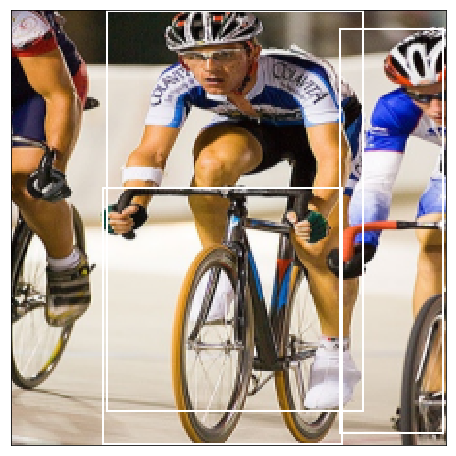

In [260]:
plot_gt(img, abc)

In [208]:
x[0]

array([[[ 0.39125,  0.43014,  0.48172, ...,  0.17518,  0.32367,  0.40783],
        [ 0.51636,  0.44973,  0.59202, ...,  0.17386,  0.23164,  0.36722],
        [ 0.54416,  0.57267,  0.70099, ...,  0.05768,  0.2232 ,  0.35455],
        ...,
        [ 1.46039,  1.50291,  1.5195 , ...,  0.7803 ,  0.56716, -0.63922],
        [ 0.93739,  1.021  ,  1.15993, ...,  1.12806,  1.08947,  0.45857],
        [ 0.58584,  0.45245,  0.29605, ...,  1.00028,  0.92495,  0.82729]],

       [[ 0.24041,  0.31444,  0.41422, ...,  0.33162,  0.47052,  0.54764],
        [ 0.39737,  0.42156,  0.57304, ...,  0.33887,  0.38799,  0.52038],
        [ 0.52462,  0.58245,  0.67485, ...,  0.2519 ,  0.40003,  0.51502],
        ...,
        [ 1.47208,  1.50185,  1.50771, ...,  0.60917,  0.44337, -0.73978],
        [ 0.84169,  0.94566,  1.06783, ...,  0.97373,  1.01637,  0.39674],
        [ 0.47731,  0.36442,  0.1823 , ...,  0.85592,  0.85008,  0.75529]],

       [[ 0.63094,  0.76758,  0.91924, ...,  0.46997,  0.58218,  0.635

In [227]:
list(np.reshape(y[0][0], (int(y[0][0].shape[0]/4), 4)))

[array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0.], dtype=float32),
 array([  0.,  49., 206., 181.], dtype=float32),
 array([  9., 169., 217., 222.], dtype=float32),
 array([ 91.,  47., 223., 170.], dtype=float32)]

In [223]:
y[0][0].shape[0]/4

14.0

In [218]:
y[0][0].shape

(56,)

In [217]:
y[1][0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

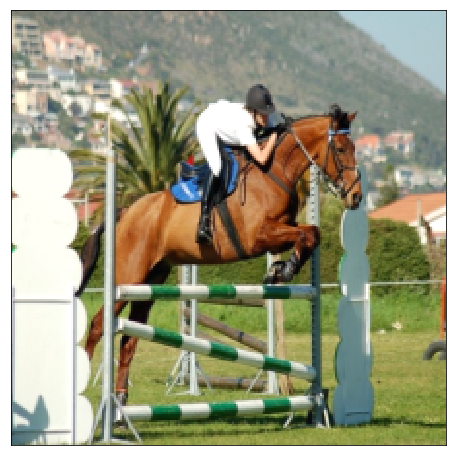

In [165]:
show_img(np.squeeze(md_mbb.val_ds.denorm(x)))

In [56]:
class FeatureExtractor(nn.Module):
    def __init__(orig_model):
        super(FeautureExtractor, self).__init__()
        self.features = nn.Sequential(*list(orig_model.children())[:-1])
    
    def forward(self, x):
        if isinstance(x, torch.autograd.variable.Variable):
            x = self.features(x)
        else:
            x = self.features(V(x))
        return x